In [1]:
import os
import shutil
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
# root_path = 'gdrive/My Drive/Colab Notebooks/Classif_img_CNN/datas/'
root_path = 'gdrive/My Drive/Simplon/'

unset HISTFILE; export PS1="root@ca9d08dde145-3d96b302cfa1486e9c484332f1751037: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@ca9d08dde145-3d96b302cfa1486e9c484332f1751037: umount -f /content/gdrive || umount /content/gdrive; pkill -9 -x drive
umount: /content/gdrive: no mount point specified.
umount: /content/gdrive: no mount point specified.
root@ca9d08dde145-3d96b302cfa1486e9c484332f1751037: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@ca9d08dde145-3d96b302cfa1486e9c484332f1751037: ( while `sleep 0.5`; do if [[ -d "/content/gdrive" && "$(ls -A /content/gdrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 187
root@ca9d08dde145-3d96b302cfa1486e9c484332f1751037: cat /tmp/tmp_q5zed0r/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_insta

In [3]:
file = ''.join(root_path+'AnimalFace.zip')
file

'gdrive/My Drive/Simplon/AnimalFace.zip'

In [4]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [5]:
IMG_SIZE = 128

In [6]:
# train folders
os.mkdir('/content/datas/train/')
for img_class in os.listdir("/content/datas/Image"):
    os.mkdir('/content/datas/train/' + img_class[:-4] + '/')

In [7]:
# test folders
os.mkdir('/content/datas/test/')
for img_class in os.listdir("/content/datas/Image"):
    os.mkdir('/content/datas/test/' + img_class[:-4] + '/')

In [8]:
# form train dataset
for img_class in tqdm(os.listdir('/content/datas/Image/')):
    img_ls = os.listdir('/content/datas/Image/' + img_class)
    for img in img_ls[:int(len(img_ls) * 0.8)]:
        shutil.copy('/content/datas/Image/' + img_class + '/' + img, 
                    '/content/datas/train/' + img_class[:-4] + '/' + img)

100%|██████████| 21/21 [00:00<00:00, 79.66it/s]


In [9]:
# form test dataset
for img_class in tqdm(os.listdir('/content/datas/Image/')):
    img_ls = os.listdir('/content/datas/Image/' + img_class)
    for img in img_ls[int(len(img_ls) * 0.8):]:
        shutil.copy('/content/datas/Image/' + img_class + '/' + img, 
                    '/content/datas/test/' + img_class[:-4] + '/' + img)

100%|██████████| 21/21 [00:00<00:00, 284.60it/s]


In [10]:
train_data_path = "/content/datas/train/"
test_data_path = "/content/datas/test/"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])

# this function get folder with images
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=transform)

test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                             transform=transform)

In [11]:
batch_size=64
train_data_loader = data.DataLoader(train_data, shuffle=True,
                                    batch_size=batch_size)

test_data_loader  = data.DataLoader(test_data, shuffle=True, 
                                    batch_size=batch_size)

In [12]:
from torchvision import models
# download pretrained ResNet
transfer_model = models.resnet50(pretrained=True)

# freeze all layers in pretrained model
for name, param in transfer_model.named_parameters():
    param.requires_grad = False
    
# replace last layer 
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),
nn.Dropout(), nn.Linear(500,21))

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device : cuba (gpu)")
else:
    device = torch.device("cpu")
    print("device : cpu")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



device : cuba (gpu)


In [13]:
model = transfer_model 
model.to(device)
# add optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0003, amsgrad=True)
epochs = 50
loss_fn = torch.nn.CrossEntropyLoss()
loss_lst, loss_val_lst = [], []

for epoch in range(epochs):
    print("epochs : ", epoch)
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_data_loader:
        optimizer.zero_grad()
        inputs, target = batch
        inputs = inputs.to(device)
        target = target.to(device)
        output = model(inputs)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item()
    loss_lst.append(training_loss)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in test_data_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output,targets)
        valid_loss += loss.data.item()
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1],
                        targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    loss_val_lst.append(valid_loss)

    print('Epoch: {}, Training Loss: {:.2f}, \
        Validation Loss: {:.2f}, \
        accuracy = {:.2f}'.format(epoch, training_loss, \
        valid_loss, num_correct / num_examples))

epochs :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 59.82,         Validation Loss: 6.85,         accuracy = 0.88
epochs :  1
Epoch: 1, Training Loss: 23.39,         Validation Loss: 4.00,         accuracy = 0.90
epochs :  2
Epoch: 2, Training Loss: 15.34,         Validation Loss: 3.15,         accuracy = 0.90
epochs :  3
Epoch: 3, Training Loss: 12.09,         Validation Loss: 2.79,         accuracy = 0.92
epochs :  4
Epoch: 4, Training Loss: 10.08,         Validation Loss: 2.46,         accuracy = 0.92
epochs :  5
Epoch: 5, Training Loss: 9.42,         Validation Loss: 2.26,         accuracy = 0.92
epochs :  6
Epoch: 6, Training Loss: 8.02,         Validation Loss: 2.11,         accuracy = 0.93
epochs :  7
Epoch: 7, Training Loss: 6.83,         Validation Loss: 2.05,         accuracy = 0.92
epochs :  8
Epoch: 8, Training Loss: 5.88,         Validation Loss: 1.99,         accuracy = 0.93
epochs :  9
Epoch: 9, Training Loss: 5.28,         Validation Loss: 1.89,         accuracy = 0.94
epochs :  10
Epoch: 10, Tra

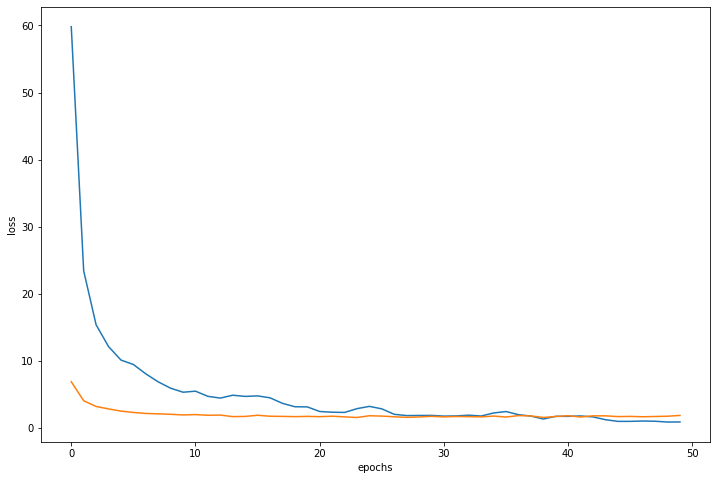

In [14]:
plt.figure(figsize=[12, 8])
plt.plot(range(len(loss_lst)), loss_lst);
plt.plot(range(len(loss_val_lst)), loss_val_lst);
plt.xlabel('epochs');
plt.ylabel('loss');

### Confusion matrix

In [15]:
all_output = np.array([])
all_targets = np.array([])

for batch in tqdm(test_data_loader):
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    all_output = np.concatenate([all_output, output.max(dim=1).indices.cpu().numpy()])
    all_targets = np.concatenate([all_targets, targets.numpy()])

100%|██████████| 8/8 [00:02<00:00,  3.47it/s]


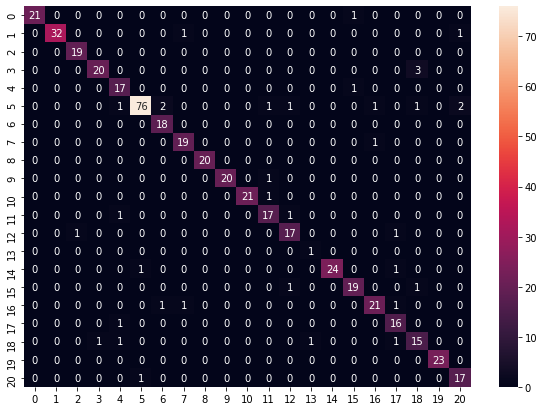

In [16]:
# plot confusion matrix
conf_matr = confusion_matrix(all_output, 
                             all_targets)
plt.figure(figsize = (10,7))
sns.heatmap(conf_matr, annot=True);

In [17]:
from skimage.transform import resize
from google.colab import files
image = files.upload()
print(image.keys())
for k, v in image.items(): pass

Saving cat450a.jpg to cat450a.jpg
dict_keys(['cat450a.jpg'])


(-0.5, 127.5, 127.5, -0.5)

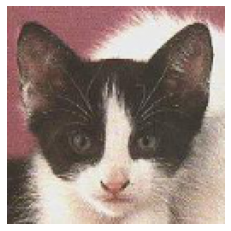

In [18]:
from skimage.io import imread
from skimage.transform import resize
im = imread(k) # 333636a798.jpeg ## fda9a545f5.jpeg
im = resize(im, (IMG_SIZE, IMG_SIZE))
plt.imshow(im)
plt.axis('off')

In [20]:
class_names=train_data.classes

In [22]:
from torch.autograd import Variable
from PIL import Image

# An instance of your model.
img_pil = Image.open(k)
#img_pil.show()
img_tensor = transform(img_pil).float()
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

fc_out = model(Variable(img_tensor))

output = fc_out.cpu().detach().numpy()
print(class_names[output.argmax()])

Cat
